In [1]:
import sys
from extraction.extract import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, TimeDistributed
from keras.callbacks import EarlyStopping
import seaborn as sns

sys.path.append(".")
pd.set_option("display.max_columns", None)


## DATA PREPARATION

In [2]:
timeinterval = 30
lookback, lookahead = 4, 4

In [3]:
# Generate single airport data and move target labels to the last 2 columns
dataset = (
    generateNNdata(
        "EHAM",
        timeslotLength=timeinterval,
        catagoricalFlightDuration=False,
        forceRegenerateData=True,
    )
    .drop(columns=["departuresArrivalDelay", "arrivalsDepartureDelay"])
    .assign(hour=lambda d: d.timeslot.dt.hour)
    .assign(capacityFilled=lambda d: d.capacityFilled * 100)
    # .query("hour>4 and hour<22")
)


Generating NN data for EHAM with a timeslot length of 30 minutes


In [4]:
# randomly split train, validation, test with 60%, 20%, 20%
np.random.seed(42)
dates = dataset.date.unique()
np.random.shuffle(dates)

idx_train = int(len(dates) * 0.6)
idx_val = int(len(dates) * 0.8)

train_dates = dates[:idx_train]
val_dates = dates[idx_train:idx_val]
test_dates = dates[idx_val:]

train_data = dataset.query("date in @train_dates")
validation_data = dataset.query("date in @test_dates")
test_data = dataset.query("date in @test_dates")


In [5]:
def genXy(data, lb, la):
    n_features = data.shape[1] - 2
    df = data.reindex()

    X = np.empty((0, lb, n_features))
    y = np.empty((0, la, 2))

    X_time = np.array([], dtype="datetime64")
    y_time = np.array([], dtype="datetime64")

    for i, row in df.iterrows():
        dfx = df.iloc[i : i + lb]
        x_vals = dfx.drop(columns=["timeslot", "date"]).values

        dfy = df.iloc[i + lb : i + lb + la]
        y_vals = dfy[["arrivalsArrivalDelay", "departuresDepartureDelay"]].values

        if dfx.date.nunique() > 1:
            continue

        if dfx.shape[0] < lb or dfy.shape[0] < la:
            continue

        X = np.vstack((X, x_vals[None]))
        y = np.vstack((y, y_vals[None]))

        X_time = np.append(X_time, dfx.timeslot.iloc[0])
        y_time = np.append(y_time, dfy.timeslot.iloc[0])

    return X, y, X_time, y_time


In [6]:
X_train, y_train, X_train_time, y_train_time = genXy(train_data, lb=lookback, la=lookahead)
X_val, y_val, X_val_time, y_val_time = genXy(validation_data, lb=lookback, la=lookahead)
X_test, y_test, X_test_time, y_test_time = genXy(test_data, lb=lookback, la=lookahead)

y_train_arr, y_train_dep = y_train[:, :, 0], y_train[:, :, 1]
y_val_arr, y_val_dep = y_val[:, :, 0], y_val[:, :, 1]
y_test_arr, y_test_dep = y_test[:, :, 0], y_test[:, :, 1]


In [7]:
print(X_train.shape)
print(y_train.shape)

(6036, 4, 12)
(6036, 4, 2)


2022-02-07 20:50:04.287125: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-02-07 20:50:04.287168: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-07 20:50:04.287188: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (omdb.lr.tudelft.nl): /proc/driver/nvidia/version does not exist
2022-02-07 20:50:04.287450: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 4, 200)            170400    
_________________________________________________________________
dropout (Dropout)            (None, 4, 200)            0         
_________________________________________________________________
time_distributed (TimeDistri (None, 4, 100)            20100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 100)            0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 4, 1)              101       
Total params: 190,601
Trainable params: 190,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


2022-02-07 20:50:04.653675: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


189/189 [==============================] - 12s 57ms/step - loss: 39.4160 - val_loss: 36.1875
Epoch 2/100
189/189 [==============================] - 8s 42ms/step - loss: 35.9982 - val_loss: 35.7607
Epoch 3/100
189/189 [==============================] - 9s 47ms/step - loss: 35.2457 - val_loss: 35.9606
Epoch 4/100
189/189 [==============================] - 9s 46ms/step - loss: 34.5996 - val_loss: 34.9420
Epoch 5/100
189/189 [==============================] - 10s 53ms/step - loss: 34.1966 - val_loss: 34.3236
Epoch 6/100
189/189 [==============================] - 11s 57ms/step - loss: 33.9518 - val_loss: 32.8580
Epoch 7/100
189/189 [==============================] - 8s 43ms/step - loss: 33.6216 - val_loss: 34.0336
Epoch 8/100
189/189 [==============================] - 9s 50ms/step - loss: 33.2579 - val_loss: 32.7013
Epoch 9/100
189/189 [==============================] - 9s 46ms/step - loss: 33.1640 - val_loss: 33.2625
Epoch 10/100
189/189 [==============================] - 8s 45ms/step - lo

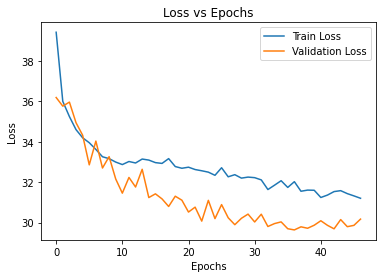

In [8]:
n_timesteps = X_train.shape[1]
n_features = X_train.shape[2]

model = Sequential()
model.add(LSTM(200, input_shape=(n_timesteps, n_features), return_sequences=True))
model.add(Dropout(0.25))
model.add(TimeDistributed(Dense(100)))
model.add(Dropout(0.25))
model.add(TimeDistributed(Dense(1)))

model.compile(loss="mse", optimizer="adam")

model.summary()

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# Fit data
history = model.fit(
    X_train,
    y_train_dep,
    epochs=100,
    validation_data=(X_val, y_val_dep),
    # verbose=0,
    shuffle=False,
    callbacks=[es],
)

# Plot loss
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [11]:
y_test_estimate = model.predict(X_test)

res = dict()
for i in range(4):
    res[(i + 1)] = {
        "dep_mae": mean_absolute_error(y_test_estimate[:, i], y_test_dep[:, i]),
        "dep_rmse": mean_squared_error(y_test_estimate[:, i], y_test_dep[:, i], squared=False),
        "dep_r2": r2_score(y_test_estimate[:, i], y_test_dep[:, i]),
    }

pd.DataFrame.from_dict(res, orient="index")


,dep_mae,dep_rmse,dep_r2
1,3.631005,5.374088,-0.851749
2,3.583645,5.406827,-0.692157
3,3.667444,5.565333,-0.578912
4,3.721355,5.622201,-0.510514


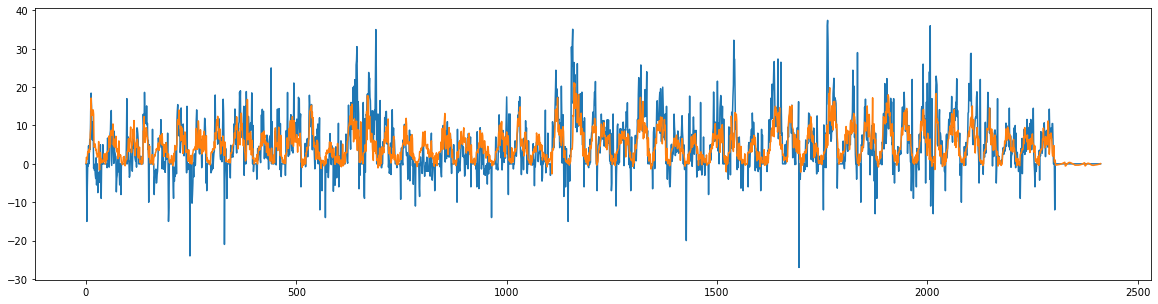

In [13]:
plt.figure(figsize=(20,5))
# plt.scatter(y_test_time, y_test_dep[:, 0])
# plt.scatter(y_test_time, y_test_estimate[:, 0])
plt.plot(y_test_dep[:, 0])
plt.plot(y_test_estimate[:, 0])

In [ ]:
y_test_estimate = model.predict(X_test)

res = dict()
for i in range(lookahead):
    res[(i + 1)] = {
        "arr_mae": mean_absolute_error(y_test_estimate[:, i], y_test_arr[:, i]),
        "arr_rmse": mean_squared_error(y_test_estimate[:, i], y_test_arr[:, i], squared=False),
        "arr_r2": r2_score(y_test_estimate[:, i], y_test_arr[:, i]),
    }

pd.DataFrame.from_dict(res, orient="index")


In [55]:
y_test_estimate = model.predict(X_test)

estimate_dep_delay = y_test_estimate
dep_delay = y_test[:, :, 1]

res = dict()
for i in range(lookahead):
    res[(i + 1)] = {
        "dep_mae": mean_absolute_error(estimate_dep_delay[:, i], dep_delay[:, i]),
        "dep_rmse": mean_squared_error(estimate_dep_delay[:, i], dep_delay[:, i], squared=False),
        "dep_r2": r2_score(estimate_dep_delay[:, i], dep_delay[:, i]),
    }

pd.DataFrame.from_dict(res, orient="index")


,dep_mae,dep_rmse,dep_r2
1,2.089307,3.328006,-0.527691
2,2.003747,3.170648,-0.215535
3,2.005046,3.142762,-0.111100
4,1.984517,3.070726,-0.019557


In [34]:
y_test_estimate = model.predict(X_test)

estimate_arr_delay = y_test_estimate[:, :, 0]
arr_delay = y_test[:, :, 0]

estimate_dep_delay = y_test_estimate[:, :, 1]
dep_delay = y_test[:, :, 1]


In [35]:
res = dict()
for i in range(lookahead):
    res[(i + 1)] = {
        "arr_mae": mean_absolute_error(estimate_arr_delay[:, i], arr_delay[:, i]),
        "arr_rmse": mean_squared_error(estimate_arr_delay[:, i], arr_delay[:, i], squared=False),
        "arr_r2": r2_score(estimate_arr_delay[:, i], arr_delay[:, i]),
        "dep_mae": mean_absolute_error(estimate_dep_delay[:, i], dep_delay[:, i]),
        "dep_rmse": mean_squared_error(estimate_dep_delay[:, i], dep_delay[:, i], squared=False),
        "dep_r2": r2_score(estimate_dep_delay[:, i], dep_delay[:, i]),
    }

pd.DataFrame.from_dict(res, orient="index")


,arr_mae,arr_rmse,arr_r2,dep_mae,dep_rmse,dep_r2
1,6.644823,9.897676,0.040459,2.174981,3.290085,-0.418775
2,6.115316,9.514633,0.202221,2.057400,3.164205,-0.137013
3,5.887999,9.411507,0.231547,2.064523,3.166651,-0.099441
4,5.914161,9.416951,0.220296,2.023534,3.058411,-0.035481


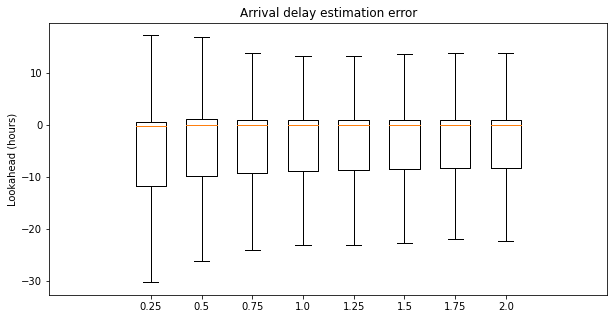

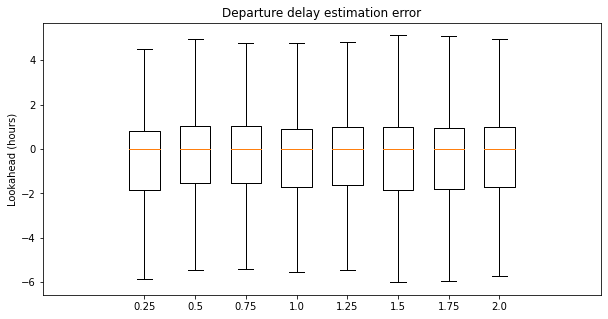

In [56]:
estimate_arrival_delay = y_test_estimate[:, :, 0].reshape(-1, 8)
actual_arrival_delay = y_test[:, :, 0].reshape(-1, 8)

estimate_departure_delay = y_test_estimate[:, :, 1].reshape(-1, 8)
actual_departure_delay = y_test[:, :, 1].reshape(-1, 8)

plt.figure(figsize=(10, 5))
for i in range(8):
    diff = estimate_arrival_delay[:, i] - actual_arrival_delay[:, i]
    plt.boxplot([diff], positions=[i/4 +0.25], showfliers=False)
    # print(mean_absolute_error(estimate_arrival_delay[:, i], actual_arrival_delay[:, i]))

plt.ylabel("minutes")
plt.ylabel("Lookahead (hours)")
plt.title("Arrival delay estimation error")
plt.show()
print()

plt.figure(figsize=(10, 5))
for i in range(8):
    diff = estimate_departure_delay[:, i] - actual_departure_delay[:, i]
    plt.boxplot([diff], positions=[i/4+0.25], showfliers=False)
    # print(mean_absolute_error(estimate_departure_delay[:, i], actual_departure_delay[:, i]))
    # print(mean_squared_error(y[:, i], yhat[:, i], squared=False))
    # print(r2_score(y[:, i], yhat[:, i]))
plt.ylabel("minutes")
plt.ylabel("Lookahead (hours)")
plt.title("Departure delay estimation error")
plt.show()


In [361]:
# def genXy(df):
#     n_features = 14
#     valid_idx = (
#         df.select_dtypes(include=np.datetime64)
#         .assign(dd=lambda d: (d.max(axis=1) - d.min(axis=1)))
#         .query(f"dd=='{pd.Timedelta(0, 'D')}'")
#         .index
#     )

#     df = df.query("index in @valid_idx").select_dtypes(exclude=np.datetime64)

#     X = df.iloc[:, 0 : int(df.shape[1] / 2)].values.reshape(df.shape[0], -1, n_features)

#     # var5 -> arrival delay
#     # var7 -> departure delay
    
#     y_mask_arr = df.iloc[:, int(df.shape[1] / 2) :].columns.str.contains("var5")
#     y_arr = (
#         df.iloc[:, int(df.shape[1] / 2) :]
#         .loc[:, y_mask_arr]
#         .values.reshape(df.shape[0], -1, 1)
#     )

#     y_mask_dep = df.iloc[:, int(df.shape[1] / 2) :].columns.str.contains("var7")
#     y_dep = (
#         df.iloc[:, int(df.shape[1] / 2) :]
#         .loc[:, y_mask_dep]
#         .values.reshape(df.shape[0], -1, 1)
#     )
#     return X, y_arr, y_dep
